Load in memory the temporal gasoline and diesel network with the fuel price of every station for every day.

This network will be mostly used as data structure to have a data fast access.

In [1]:
import raphtory as rp

# Load the temporal networks for gasoline and diesel prices in Lombardia
lombardia_gasoline = rp.Graph.load_from_file("../network/same_price/same_price_lombardia_stations_gasoline")
lombardia_diesel = rp.Graph.load_from_file("../network/same_price/same_price_lombardia_stations_diesel")

Loading in memory the distance network, these networks contain the connection between stations separated from x km with x that goes from 1 to 5.
Example the distance network 2 connects two stations if are separated from less or equal than 2km but more than 1km.

These network have been created in the notebook called NetworkCreation, and will be used to run some analysis on it.

In [2]:
import networkx as nx

distances_network = {}

distances = [1, 2, 3, 4, 5]

# Load the distance networks for each specified distance in kilometers
for km in distances:
    distances_network[km] = nx.read_gexf(f"../network/distance/{km}_km_distance_network_Lombardia.gexf")

Because we are going to work with the prices of the stations, we remove from the distances network, using the diesel and gasoline prices network, every node for which we don't have any daily information about the price.

In [3]:
no_price = []

for node in distances_network[1].nodes:

    if lombardia_gasoline.node(node) is None or lombardia_diesel.node(node) is None:
        no_price.append(node)

for node in no_price:
    for km in distances:
        distances_network[km].remove_node(node)

Given the distances network and the prices network  we are goin to add a **matching percentage** on every edge in the networks.

We have a **match** if for example given the station A connected to the station B the second one follows the direction in price change (the price can go up or down ora remain the same) of A with a difference in price between the two that is less than 0.02 Euro cent, the number of match are then divide by the total number of observation and multiplied by 100 making the percentage of match over the total number of observation and saved as attribute on the edge. 

The matching day are calculated on every distances network, from 1km to 5km and for every distance network with 6 different days of **lag** from 0 to 5.

From now on we will referring for the **matching percentage** only as **matching** in order to keep everything less complicated.

**Lag** equal to 0 means that we have a match if the two connceted stations change price at the same moment so day by day.

**Lag** more than 0 means that we have a match if given the station A connected to B this changes his price in the same way of A after **lag** days.

We have to change every network from undirected to directed, so from every node now we doesn't have one undirected edges but two directed edges.
This because for **lag** 0 the match from A to B is the same from B to A because the prices are changed for both stations simultaneously, this is not the case with **lag** bigger tha 0 because a match from the station A to B is different than from B to A, this will help us understand if it's the station A that change following B or B that change following the price proposed by A.

So for **lag** equal to 0 we will have the same matching percentage from A to B and from B to A, but for **lag** bigger than 0 will very likely be different. 

In [4]:
import datetime

def matching(distances_network, price_network, start_date, end_date, lag):

    actual_date = start_date

    # Iterate through each distance network
    for km in distances_network:

        # Ensure the network is directed
        # If the network is undirected, convert it to directed
        # This is necessary to ensure from where the match comes from
        if not distances_network[km].is_directed():
            distances_network[km] = distances_network[km].to_directed()
            

        for node in distances_network[km].nodes:

            fixed_node = price_network.node(node)

            # Iterate through each neighbor of the node
            for neighbor in distances_network[km].neighbors(node):

                neighbor_node = price_network.node(neighbor)

                matching_days = 0
                total_days = 0

                actual_date = start_date

                # Iterate through the dates in the specified range
                # This loop checks the price changes for the fixed node and its neighbor
                # and counts the days where both prices change in the same direction or remain unchanged
                # The lag is used to compare the price of the neighbor node with a lag of 'lag' days
                while( (actual_date + datetime.timedelta(days=lag+1)) <= end_date ):

                    # Skip if the node or neighbor node does not have data about the price for the current date
                    try:
                        # Calculate the price change for the fixed node is always the difference between the price of the next day and the current day
                        price_fixed = float(fixed_node.at(actual_date + datetime.timedelta(days=1)).properties["prezzo"])
                        change_fixed = price_fixed - float(fixed_node.at(actual_date).properties["prezzo"])

                        # Calculate the price change for the neighbor node with a lag of 'lag' days, is the difference between the price of the current day plus 'lag+1' 
                        # days and the price of the current day plus 'lag' days
                        #
                        # Example 
                        # lag = 2, Current day = 1
                        # change_fixed = price[2] - price[1]
                        # the change is between day 1 and 2, so with a lag of 2 we have to check price change after 2 days
                        # so between day 4 and 2
                        # change_neighbor = price[4] - price[3]
                        price_neighbor = float(neighbor_node.at(actual_date + datetime.timedelta(days=lag+1)).properties["prezzo"])
                        change_neighbor = price_neighbor - float(neighbor_node.at(actual_date + datetime.timedelta(days=lag)).properties["prezzo"])

                        total_days += 1
                        # If both changes are in the same direction or both are zero (no price change), count it as a matching day
                        if change_fixed * change_neighbor > 0 and abs(price_fixed - price_neighbor) <= 0.02:
                            matching_days += 1
                        elif change_fixed == 0 and change_neighbor == 0 and abs(price_fixed - price_neighbor) <= 0.02:
                            matching_days += 1
                    except:
                        pass

                    actual_date += datetime.timedelta(days=1)

                # Store the matching percentage in the distances_network
                name = f"{lag}_matching"
                if total_days == 0:
                    # If there are no days with matching prices, set the matching percentage to -1
                    distances_network[km][neighbor][node][name] = -1
                else:
                    distances_network[km][neighbor][node][name] = round((matching_days / total_days)*100,2)

    return distances_network      

In [5]:
def removing_null_edges(distances_network):
    """
    Remove edges with no matching percentage from the distances network.
    """
    null_edges = set()

    # Iterate through each distance network
    for km in distances_network:
        
        for edge in distances_network[km].edges(data=True):
            if edge[2]["5_matching"] == -1:
                null_edges.add((km, edge[0], edge[1]))
                null_edges.add((km, edge[1], edge[0]))
    
    # Remove edges with no matching percentage
    for edge in null_edges:
        distances_network[edge[0]].remove_edge(edge[1], edge[2])
    
    return distances_network

In [6]:
import os

price_matching_network_gasoline = distances_network.copy()
price_matching_network_diesel = distances_network.copy()

region_name = "Lombardia"

# Check if the GEXF files for the price matching networks already exist
# If they do, load them; otherwise, calculate the networks
# and save them to GEXF files
# This avoids recalculating the networks if they have already been computed
# and stored in the specified directory
# The GEXF files are named according to the distance in kilometers and the region name
# For example, for 1 km distance and Lombardia region, the file name is:
# "1_km_price_matching_network_Lombardia_gasoline.gexf"
# and "1_km_price_matching_network_Lombardia_diesel.gexf"
if(os.path.exists(f"../network/price_matching/1_km_price_matching_network_{region_name}_gasoline.gexf")):

    for km in distances:
        price_matching_network_gasoline[km] = nx.read_gexf(f"../network/price_matching/{km}_km_price_matching_network_{region_name}_gasoline.gexf")
        price_matching_network_diesel[km] = nx.read_gexf(f"../network/price_matching/{km}_km_price_matching_network_{region_name}_diesel.gexf")

else:
    
    start_date = datetime.datetime(2025, 4, 1)
    end_date = datetime.datetime(2025, 6, 30)

    #  Calculate the price matching networks for gasoline and diesel with lags from 0 to 5 days
    for lag in range (0,6):
        price_matching_network_gasoline = matching(price_matching_network_gasoline, lombardia_gasoline, start_date, end_date,lag)
        price_matching_network_diesel = matching(price_matching_network_diesel, lombardia_diesel, start_date, end_date,lag)
    
    # Remove edges with no matching percentage
    price_matching_network_gasoline = removing_null_edges(price_matching_network_gasoline)
    price_matching_network_diesel = removing_null_edges(price_matching_network_diesel)

    # Write the resulting networks to GEXF files with unique IDs for edges
    for km in distances:

        id_counter = 0
        for edge in price_matching_network_gasoline[km].edges(data=True):
            price_matching_network_gasoline[km][edge[0]][edge[1]]["id"] = id_counter
            id_counter += 1
        
        id_counter = 0
        for edge in price_matching_network_diesel[km].edges(data=True):
            price_matching_network_diesel[km][edge[0]][edge[1]]["id"] = id_counter
            id_counter += 1
            
        file_name = f"../network/price_matching/{km}_km_price_matching_network_{region_name}_gasoline.gexf"
        nx.write_gexf(price_matching_network_gasoline[km], file_name)

        file_name = f"../network/price_matching/{km}_km_price_matching_network_{region_name}_diesel.gexf"
        nx.write_gexf(price_matching_network_diesel[km], file_name)

After calculating the matching between every stations we check and extract the influencers and the high matching edges inside the networks.

A high matching edge is an edge that have (for a fixed km and lag) a matching higher than 50.

An influencer is a node with (for a fixed km and lag) at least the 50% of his in coming edge with a **matching equal or higher than 50**.

Both the influencers and the high matching edge are calculated for every km and every days of lag.

In [7]:
# Function to identify high matching nodes and influencers in the price matching network
def high_matching_and_influencers(price_matching_network):
    influencers = {}
    high_matching_edges = {}

    # Iterate through each distance network in the price matching network
    for km in price_matching_network:

        influencers[km] = {}
        high_matching_edges[km] = {}

        # Iterate through each node in the distance network
        for node in price_matching_network[km].nodes():
            G = price_matching_network[km]

            # Initialize the influencers and high matching edges for each lag
            for lag in range(0, 6):

                if lag not in influencers[km]:
                    influencers[km][lag] = set()
                    high_matching_edges[km][lag] = set()

                counter = 0
                in_edges = G.in_edges(node, data=True)
                for edge in in_edges:

                    # If the matching percentage is greater than 50%, count it as a high matching edge
                    if edge[2][f"{lag}_matching"] > 50:
                        counter += 1

                        # Add the edge to the high matching edges set
                        # Ensure the edge is stored in a consistent order (lower ID first)
                        # This is to avoid duplicates like (1,2) and (2,1)
                        high_matching_edges[km][lag].add((edge[1],edge[0]))
                
                # If there are valid edges and the percentage of high matching edges is greater than or equal to 50%, add the node as an influencer
                if len(in_edges) > 0 and counter / len(in_edges) >= 0.5:
                    influencers[km][lag].add(node)

    # Return the influencers and high matching edges for each distance network
    return influencers, high_matching_edges

influencers_gasoline, high_matching_gasoline = high_matching_and_influencers(price_matching_network_gasoline)
influencers_diesel, high_matching_diesel = high_matching_and_influencers(price_matching_network_diesel)

Printing the number of nodes and edges for every distance network.

In [8]:
for l in price_matching_network_gasoline:
    print(f"Network for {l} km distance loaded with {len(price_matching_network_gasoline[l].nodes())} nodes and {len(price_matching_network_gasoline[l].edges())} edges.")

Network for 1 km distance loaded with 2661 nodes and 2870 edges.
Network for 2 km distance loaded with 2661 nodes and 7740 edges.
Network for 3 km distance loaded with 2661 nodes and 12262 edges.
Network for 4 km distance loaded with 2661 nodes and 17130 edges.
Network for 5 km distance loaded with 2661 nodes and 20638 edges.


In [9]:
for l in price_matching_network_gasoline:
    print(f"Network for {l} km distance loaded with {len(price_matching_network_diesel[l].nodes())} nodes and {len(price_matching_network_diesel[l].edges())} edges.")

Network for 1 km distance loaded with 2661 nodes and 2870 edges.
Network for 2 km distance loaded with 2661 nodes and 7740 edges.
Network for 3 km distance loaded with 2661 nodes and 12262 edges.
Network for 4 km distance loaded with 2661 nodes and 17130 edges.
Network for 5 km distance loaded with 2661 nodes and 20638 edges.


Printing the percentage of influencer over the total of nodes, and the percentage of high matching edges over the total of edges for every km and day of lag.

After giving a quick view of the data we can see that increasing in **km** and **lag** reduce the percentage of influencers and high matching edges present in the networks, this means that by more km are the stations divided less the possibility thet they have an high influence over each other, and the more days pass after a change in price from a station less the possibility that another stations will adapt to the new price

If we look closer in this negative trend we can see, that the decreasing difference in the high matching edges from lag 0 to lag 1 is negligible always less than 1%, same for the number of influencer that in some case it will also increase.

We also have to keep in mind that as concern the lag 0 every high matching nodes goes in two directions because the change in price it is simultaneous, A change with B and B with A, if we want to be precise the number of high matching edge for 0 lag should be divided by two.
We can also have between two different stations mutual edges with lag greater than 0 but in this case the information obtained is different, it tells us that the two stations adapt to each other continuously after a certain number of days.

In [10]:
import plotly.express as px

# Function to visualize the percentage of influencers and high matching edges in the price matching network
def print_hign_matching_and_influencers(price_matching_network, influencers, high_matching_edges,fuel_type):
    
    data_influencers,data_high_matching  = [], []

    for km in influencers:

        total_edges = len(price_matching_network[km].edges())
        total_nodes = len(price_matching_network[km].nodes())

        row_influencers,row_high_matching = [], []

        for lag in influencers[km]:

            row_influencers.append(round(len(influencers[km][lag]) / total_nodes*100,2))
            row_high_matching.append(round(len(high_matching_edges[km][lag]) / total_edges*100,2))

        data_influencers.append(row_influencers)
        data_high_matching.append(row_high_matching)

    fig_influencers = px.imshow(data_influencers, text_auto=True, 
                    aspect="auto", 
                    title=f"<b>Influencers</b> in <b>{fuel_type}</b> price matching network", 
                    labels=dict(x="Days of Lag", y="Distance (km)", color="%"),
                    y=["1", "2", "3", "4", "5"],color_continuous_scale='turbid')
    fig_influencers.update_xaxes(side="top")
    
    fig_high_matching = px.imshow(data_high_matching, text_auto=True, 
                    aspect="auto", 
                    title=f"<b>High matching edges</b> in <b>{fuel_type}</b> price matching network", 
                    labels=dict(x="Days of Lag", y="Distance (km)", color="%"),
                    y=["1", "2", "3", "4", "5"],color_continuous_scale='turbid')
    fig_high_matching.update_xaxes(side="top")

    fig_influencers.show()
    fig_high_matching.show()

print_hign_matching_and_influencers(price_matching_network_gasoline,influencers_gasoline,high_matching_gasoline,"Gasoline")

In [11]:
print_hign_matching_and_influencers(price_matching_network_diesel,influencers_diesel,high_matching_diesel,"Diesel")

After the quick observations made previously I've decided to merge for both fuels the 1,2 and 3km network and make further analysis.

In [ ]:
price_matching_network_gasoline_3km = price_matching_network_gasoline[1].copy()
price_matching_network_gasoline_3km.update(price_matching_network_gasoline[2])
price_matching_network_gasoline_3km.update(price_matching_network_gasoline[3])
    
price_matching_network_diesel_3km = price_matching_network_diesel[1].copy()
price_matching_network_diesel_3km.update(price_matching_network_diesel[2])
price_matching_network_diesel_3km.update(price_matching_network_diesel[3])

counter = 1
for edge in price_matching_network_gasoline_3km.edges(data=True):
    price_matching_network_gasoline_3km[edge[0]][edge[1]] = counter
    price_matching_network_diesel_3km[edge[0]][edge[1]] = counter
    counter += 1

The heatmap shows the percentage over the total of edges with a certain amount of Matching in different lag days.

As we can see increasing the **Matching** and the days of lag we have less edges, this means that the edge with a high **Matching** are only a little part of the total.

This is useful to quickly understand how the **Matching** is distribuited inside the network.



In [13]:
def matching_table(price_matching_network, fuel_type):

    matching = []

    for lag in range(0,6):

        row = []
        for i in range(0,10):
            row.append(0)

        for edge in price_matching_network.edges(data=True):

            aux = (edge[2][f"{lag}_matching"] // 10)
            if aux == 10:
                aux -= 1
            
            row[int(aux)] += 1

        for i in range(0,10):
            row[i] = round(row[i]/len(price_matching_network.edges())*100,2)
        
        matching.append(row)
    
    fig = px.imshow(matching, text_auto=True, 
                                aspect="auto", 
                                title=f"<b>Matching percentage of edges</b> in <b>{fuel_type}</b> price matching network 3km", 
                                labels=dict(x="Matching", y="Days of lag", color="% of edges <br>over total <br>in the network"),
                                x=["0≤x<10","10≤x<20", "20≤x<30", "30≤x<40", "40≤x<50", "50≤x<60","60≤x<70","70≤x<80","80≤x<90","90≤x≤100"],color_continuous_scale='turbid')
    fig.update_xaxes(side="top")

    fig.show()
    return matching

high_matching_gasoline_3km = matching_table(price_matching_network_gasoline_3km,"Gasoline")

In [14]:
high_matching_diesel_3km = matching_table(price_matching_network_diesel_3km,"Diesel")

The bar graph shows the percentage of influencers for the different days of lag, this is the same result obtained previuosly, with the increasing of the lag th number of incluencer decrease. 

In [15]:
import plotly.graph_objects as go

def influencers_table(price_matching_network, fuel_type):

    inf = {}

    for lag in range(0,6):
        for node in price_matching_network_gasoline_3km.nodes():
    
            in_edges = price_matching_network.in_edges(node, data=True)

            high = 0
            for edge in in_edges:
                if edge[2][f"{lag}_matching"] > 50:
                    high += 1

            if lag not in inf:
                inf[lag] = []

            if len(in_edges) > 0 and high/len(in_edges) >= 0.5:
                inf[lag].append(node)
    
    display = {}
    for lag in range(0,6):
        display[lag] = round(len(inf[lag])/len(price_matching_network.nodes())*100,2)

    fig = go.Figure([go.Bar(x=list(display.keys()), y=list(display.values()),
                    text=list(display.values()),
                    textposition='auto',
                    )])
    
    fig.update_layout(title_text=f'Percentage of <b>influencers</b> in <b>{fuel_type}</b> price matching network 3km', xaxis_title="Days of lag", yaxis_title="%")
    fig.update_traces(marker_color='#896C6C')

    fig.show()
    
    return inf

influencers_gasoline_3km = influencers_table(price_matching_network_gasoline_3km, "Gasoline")

In [16]:
influencers_diesel_3km = influencers_table(price_matching_network_diesel_3km, "Diesel")

The blu bars in the graph shows the percentage of the first 10 stations brand all over the network, while the red bars shows the percentage for the same brands but using only the influencers.

The chosen influencers are from the most popolous day of lag, 1 for the gasoline (14.51% over the entire network) and 0 for the diesel (12.06% over the entire network).

As we can see for the gasoline the largest difference is the Q8 less present inside the influencer same thing for the diesel network which however compensates with the Tamoil.

In [17]:
def brand_counter(list_of_node, elem):

    all_brand = {}

    for node in list_of_node:

        node_brand = lombardia_gasoline.node(node).properties["Bandiera"]

        if node_brand not in all_brand:
            all_brand[node_brand] = 1
        else:
            all_brand[node_brand] += 1
        
    for brand in all_brand:
        all_brand[brand] = round(all_brand[brand]/len(list_of_node)*100,2)

    return {k: v for k, v in sorted(all_brand.items(), key=lambda item: item[1], reverse=True)[:elem]}   

In [18]:
def brand_comparation(price_matching_network_3km, influencers_3km, days_lag, fuel_type):

    all_brand = brand_counter(price_matching_network_3km, 10)

    influencers_brand = brand_counter(influencers_3km[days_lag], len(influencers_3km[days_lag]))
    influencers_brand = {key: influencers_brand[key] for key in influencers_brand if key in list(all_brand.keys())}

    fig = go.Figure(data=[

    go.Bar(name='Brand % <br>in all network', x=list(all_brand.keys()), y=list(all_brand.values()), text=list(all_brand.values())),
    go.Bar(name=f'Brand % <br>in influencers <br>after {days_lag} lag', x=list(influencers_brand.keys()), y=list(influencers_brand.values()), text=list(influencers_brand.values()))
    ])

    fig.update_layout(title_text=f'Percentage of <b>station brand</b> in <b>{fuel_type}</b> price matching network 3km',barmode='group')
    fig.show()

brand_comparation(price_matching_network_gasoline_3km, influencers_gasoline_3km, 1, "Gasoline")
brand_comparation(price_matching_network_diesel_3km, influencers_diesel_3km, 0, "Diesel")

In [19]:
matchi = 0
same = 0

for edge in price_matching_network_gasoline_3km.edges(data=True):

    if edge[2]["1_matching"] > 50:
        matchi += 1

        if lombardia_gasoline.node(edge[0]).properties["Bandiera"] == "Q8" and lombardia_gasoline.node(edge[1]).properties["Bandiera"] == "Tamoil":
            same += 1
        
        if lombardia_gasoline.node(edge[1]).properties["Bandiera"] == "Q8" and lombardia_gasoline.node(edge[0]).properties["Bandiera"] == "Tamoil":
            same += 1

    
print(same/matchi) 
print(matchi,same)

0.022528865108420164
3551 80


In [20]:
price_matching_network_gasoline_3km_u = price_matching_network_gasoline_3km.to_undirected()

price_matching_network_diesel_3km_u = price_matching_network_diesel_3km.to_undirected()

degree = dict(price_matching_network_gasoline_3km_u.degree(weight = 'weight'))
degree_values = list(degree.values())

Values less than or equal to 0 in data. Throwing out 0 or negative values


Likelihood ratio R: -1119.1126902873893
p-value: 5.844406788454104e-256


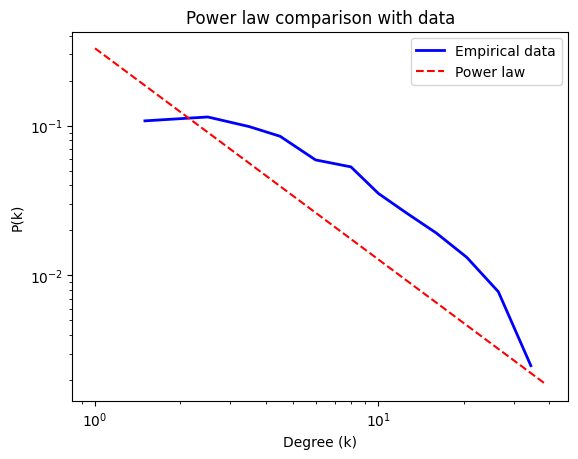

In [21]:
import matplotlib.pyplot as plt
import powerlaw

# Distribution fit
fit = powerlaw.Fit(degree_values, xmin=1, discrete=True)

# Power law vs exponential comparison
R, p = fit.distribution_compare('power_law', 'exponential')
print("Likelihood ratio R:", R)
print("p-value:", p)

# Interpretation:
# - R > 0 and p < 0.05 → more likely power law
# - R < 0 an p < 0.05 → more likely exponential
# - p hign → non significant difference

# Plotting the degree distribution and the power law fit
fig = fit.plot_pdf(color='b', linewidth=2, label='Empirical data')
fit.power_law.plot_pdf(color='r', linestyle='--', ax=fig, label='Power law')
plt.xlabel("Degree (k)")
plt.ylabel("P(k)")
plt.legend()
plt.title("Power law comparison with data")
plt.show()

In [22]:
R, p = fit.distribution_compare('power_law', 'lognormal')
print("Likelihood ratio R:", R)
print("p-value:", p)

# Interpretation:
# - R > 0 and p < 0.05 → more likely power law
# - R < 0 an p < 0.05 → more likely lognormal
# - p hign → non significant difference

Likelihood ratio R: -1051.004504795126
p-value: 9.708210128449234e-212


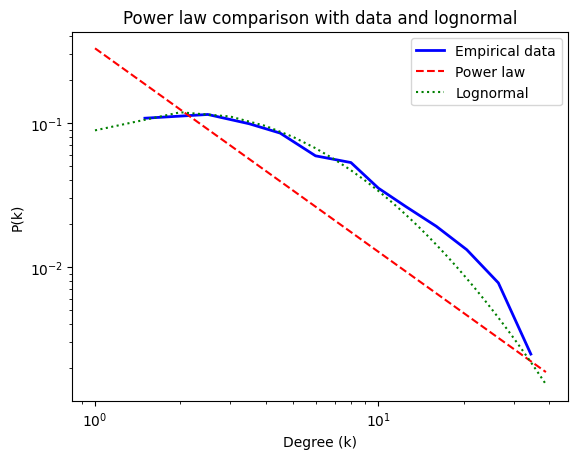

In [23]:
import matplotlib.pyplot as plt

fig = fit.plot_pdf(color='b', linewidth=2, label='Empirical data')
fit.power_law.plot_pdf(color='r', linestyle='--', ax=fig, label='Power law')
fit.lognormal.plot_pdf(color='g', linestyle=':', ax=fig, label='Lognormal')
plt.xlabel("Degree (k)")
plt.ylabel("P(k)")
plt.legend()
plt.title("Power law comparison with data and lognormal")
plt.show()



----Comparisons----

power_law vs exponential: R=-1119.113, p=0.000
more likely to be a exponential distibution

power_law vs lognormal: R=-1051.005, p=0.000
more likely to be a lognormal distibution

lognormal vs exponential: R=-68.108, p=0.000
more likely to be a exponential distibution



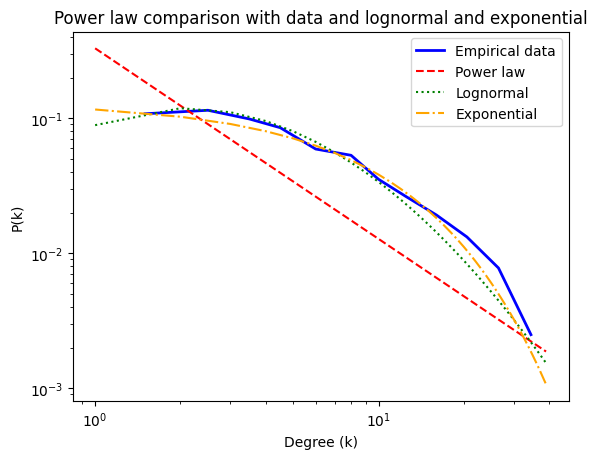

In [24]:
# Statistical comparisons between power law, lognormal and exponential
def comparison(fit, dist1, dist2):
    R, p = fit.distribution_compare(dist1, dist2)

    dist1 = '\033[91m' + dist1 + '\033[0m'
    dist2 = '\033[91m' + dist2 + '\033[0m'

    print(f"{dist1} vs {dist2}: R={R:.3f}, p={p:.3f}")

    if p < 0.05:

        if R > 0:
            print(f"more likely to be a {dist1} distibution")
        else:
            print(f"more likely to be a {dist2} distibution")

    else:
        print("No significant difference")
    
    print("")

print("\n----Comparisons----\n")
comparison(fit, 'power_law', 'exponential')
comparison(fit, 'power_law', 'lognormal')
comparison(fit, 'lognormal', 'exponential')


# Graph for comparisons
fig = fit.plot_pdf(color='b', linewidth=2, label='Empirical data')
fit.power_law.plot_pdf(color='r', linestyle='--', ax=fig, label='Power law')
fit.lognormal.plot_pdf(color='g', linestyle=':', ax=fig, label='Lognormal')
fit.exponential.plot_pdf(color='orange', linestyle='-.', ax=fig, label='Exponential')
plt.xlabel("Degree (k)")
plt.ylabel("P(k)")
plt.legend()
plt.title("Power law comparison with data and lognormal and exponential")
plt.show()


In [25]:
import statistics

mean = statistics.mean(degree_values)

lambda_value = 1 / mean

expon_variance = 1 / (lambda_value ** 2)
variance = statistics.variance(degree_values)

print("The difference between the sample variance and the estimated distribution variance is",abs(expon_variance-variance))

The difference between the sample variance and the estimated distribution variance is 1.073962135801473


In [26]:
node_mean_price = {}
node_std_price = {}

for node in price_matching_network_gasoline_3km_u.nodes(data=True):

    history = lombardia_gasoline.node(node[0]).history()

    if len(history) > 20:
        prices = list()
        for date in history:
            prices.append(float(lombardia_gasoline.node(node[0]).at(date).properties["prezzo"]))

        std = round(statistics.stdev(prices),3)
        price_median = round(statistics.median(prices),3)

    node_mean_price[node[0]] = price_median
    node[1]["price"] = price_median

In [27]:
'''
import csv

distances = {}
with open("..//dataset//stations_distances_Lombardia.csv", 'r', encoding="utf-8") as data:

    for line in csv.DictReader(data, delimiter=","):
        if line["Source"] not in distances:
            distances[line["Source"]] = {}
        distances[line["Source"]][line["Destination"]] = float(line["Distance"])
'''

'\nimport csv\n\ndistances = {}\nwith open("..//dataset//stations_distances_Lombardia.csv", \'r\', encoding="utf-8") as data:\n\n    for line in csv.DictReader(data, delimiter=","):\n        if line["Source"] not in distances:\n            distances[line["Source"]] = {}\n        distances[line["Source"]][line["Destination"]] = float(line["Distance"])\n'

In [28]:
'''
for edge in price_matching_network_gasoline_3km_u.edges(data=True):

    aux = 0
    if edge[0] in distances and edge[1] in distances[edge[0]]:
        aux = distances[edge[0]][edge[1]]
    else:
        aux = distances[edge[1]][edge[0]]
    
    edge[2]["weight"] = 1/aux
'''

'\nfor edge in price_matching_network_gasoline_3km_u.edges(data=True):\n\n    aux = 0\n    if edge[0] in distances and edge[1] in distances[edge[0]]:\n        aux = distances[edge[0]][edge[1]]\n    else:\n        aux = distances[edge[1]][edge[0]]\n\n    edge[2]["weight"] = 1/aux\n'

In [29]:
for edge in price_matching_network_gasoline_3km_u.edges(data=True):

    aux = edge[2]["0_matching"]
    if aux < 1:
        aux = 1

    edge[2]["weight"] = aux

In [30]:
import pandas as pd
from distinctiveness.dc import distinctiveness

centrality_type = {}

centrality_type["Degree_centr"] = nx.degree_centrality(price_matching_network_gasoline_3km_u)

centrality_type["Betweenness"] = nx.betweenness_centrality(price_matching_network_gasoline_3km_u, normalized=True)

#centrality_type["Information"] = nx.information_centrality(price_matching_network_gasoline_3km_u, weight="weight")

centrality_type["Closeness"] = nx.closeness_centrality(price_matching_network_gasoline_3km_u)

centrality_type["Eigen_no_w"] = nx.eigenvector_centrality(price_matching_network_gasoline_3km_u, max_iter=1000, weight=None)

centrality_type["Eigen_w"] = nx.eigenvector_centrality(price_matching_network_gasoline_3km_u, max_iter=1000, weight="weight")

centrality_type["Load_no_w"] =  nx.load_centrality(price_matching_network_gasoline_3km_u, weight=None)

centrality_type["Harmonic"] =  nx.load_centrality(price_matching_network_gasoline_3km_u)

centrality_type["Load_weight"] = nx.load_centrality(price_matching_network_gasoline_3km_u, weight="weight") 

centrality_type["Percolation"] = nx.percolation_centrality(price_matching_network_gasoline_3km_u, weight="weight") 

#centrality_type["Second_order"] = nx.second_order_centrality(price_matching_network_gasoline_3km_u, weight="weight") 

#centrality_type["Trophic_levels"] = nx.trophic_levels(price_matching_network_gasoline_3km_u, weight="weight") 

centrality_type["Laplacian"] = nx.laplacian_centrality(price_matching_network_gasoline_3km_u)

D1 = distinctiveness(price_matching_network_gasoline_3km_u, alpha = 1, normalize=True, measures = ["D1"])
centrality_type["Distinctive"] = D1["D1"]

WARNING. Normalization of D3 is carried out using loose upper and lower bounds.


In [31]:
import pandas as pd
from scipy.stats import spearmanr, pearsonr

def correlation_price_centrality(price,centrality,type):

    # Costruisco un DataFrame
    df = pd.DataFrame({
    "station_id": list(price.keys()),
    "centrality": [centrality[n] for n in list(price.keys())],
    "price_median": [price[n] for n in list(price.keys())]
    })

    # Analizzo le correlazioni
    rho_s, p_s = spearmanr(df["centrality"], df["price_median"])
    rho_p, p_p = pearsonr(df["centrality"], df["price_median"])
    print(f"{type} \t --> Spearman r={rho_s:.3f} (p={p_s:.3f}), Pearson r={rho_p:.3f} (p={p_p:.3f})")


for centrality in centrality_type:
    correlation_price_centrality(node_mean_price, centrality_type[centrality], centrality)

Degree_centr 	 --> Spearman r=-0.174 (p=0.000), Pearson r=-0.023 (p=0.228)
Betweenness 	 --> Spearman r=-0.160 (p=0.000), Pearson r=-0.022 (p=0.249)
Closeness 	 --> Spearman r=-0.173 (p=0.000), Pearson r=-0.031 (p=0.111)
Eigen_no_w 	 --> Spearman r=-0.179 (p=0.000), Pearson r=-0.076 (p=0.000)
Eigen_w 	 --> Spearman r=-0.159 (p=0.000), Pearson r=0.009 (p=0.660)
Load_no_w 	 --> Spearman r=-0.161 (p=0.000), Pearson r=-0.021 (p=0.276)
Harmonic 	 --> Spearman r=-0.161 (p=0.000), Pearson r=-0.021 (p=0.276)
Load_weight 	 --> Spearman r=0.018 (p=0.359), Pearson r=0.056 (p=0.004)
Percolation 	 --> Spearman r=0.018 (p=0.341), Pearson r=0.057 (p=0.003)
Laplacian 	 --> Spearman r=-0.276 (p=0.000), Pearson r=-0.169 (p=0.000)
Distinctive 	 --> Spearman r=-0.280 (p=0.000), Pearson r=-0.248 (p=0.000)


In [64]:
from scipy.stats import f_oneway

res = 1
F_pre = 0
counter = 1
flag = False
while(True):

    if flag:
        counter -= 1

    if counter == 0:
        res -= 101
        break

    communities = []

    for community in nx.community.louvain_communities(price_matching_network_gasoline_3km_u, weight='weight', resolution=res, seed=31):
        if len(community) > 1:
            communities.append(community)
    
    communities_prices = list()
    for community in communities:
        communities_prices.append([node_mean_price[node] for node in community])

    F_actual, p_value = f_oneway(*communities_prices)

    if F_actual > F_pre:
        F_pre = F_actual
        flag = False
    else:
        if not flag:
            counter = 100
        flag = True
    
    res += 1

communities_numbered = {i:e for i, e in enumerate(communities)}

for i, com in communities_numbered.items():
    for n in com:
        price_matching_network_diesel_3km_u.nodes[n]["com"] = i

file_name = f"../network/price_matching/price_matching_network_lombardia_gasoline_3km_u.gexf"
nx.write_gexf(price_matching_network_diesel_3km_u,file_name)